# A4: Authorship

In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, sent_tokenize
from nltk import ngrams, pos_tag
import nltk
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import SVC
import numpy as np
from string import punctuation, ascii_uppercase

In [2]:
# Download the 'stopwords' and 'punkt' from the Natural Language Toolkit, you can comment the next lines if already present.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nils\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nils\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nils\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Load the dataset into memory from the filesystem
def load_data(dir_name):
    return sklearn.datasets.load_files('data/%s' % dir_name, encoding='utf-8')


def load_train_data():
    return load_data('train')


def load_test_data():
    return load_data('test')

In [4]:
# Classify using the features
def classify(train_features, train_labels, test_features):
    clf = SVC(kernel='linear')
    clf.fit(train_features, train_labels)
    return clf.predict(test_features)

In [5]:
# Evaluate predictions (y_pred) given the ground truth (y_true)
def evaluate(y_true, y_pred):
    # TODO: What is being evaluated here and what does it say about the performance? Include or change the evaluation
    # TODO: if necessary.
    # A: y_true is the actual author, while y_pred is the predicted author by the program. These values are fairly 
    # representative about the quality of a classifier and the features.
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='macro')
    print("Recall: %f" % recall)

    precision = sklearn.metrics.precision_score(y_true, y_pred, average='macro')
    print("Precision: %f" % precision)

    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    print("F1-score: %f" % f1_score)

    return recall, precision, f1_score

In [116]:
# Extract features from a given text
def extract_features(text):
    bag_of_words = [x for x in wordpunct_tokenize(text)]
    sentences = [x for x in sent_tokenize(text)]

    features = []

    # Example feature 1: count the number of words
    features.append(len(bag_of_words))
    
    # Example feature 2: count the number of words, excluded the stopwords
    no_stopwords = [x for x in bag_of_words if x.lower() not in stop_words]
    features.append(len(no_stopwords))

    # Feature 2-4: take top k most frequent word counts
    k = 3
    freq_dict = {i:no_stopwords.count(i) for i in set(no_stopwords)}
    features.extend(sorted(freq_dict.values(), reverse=True)[:k])
    n = k - len(freq_dict)
    while n > 0:
        features.append(0)
        n -= 1
    
    # Feature 5: number of stopwords
    features.append(len([x for x in bag_of_words if x.lower() in stop_words]))
    
    # Feature 6: average sentence length
    sentence_lengths = [len(x) for x in sentences]
    features.append(sum(sentence_lengths) / len(sentence_lengths))
    
    # Feature 7-24: top m most frequent characters
    m = 17
    chars = list(text)
    char_dict = {i:chars.count(i) for i in set(chars)}
    #features.extend(sorted(char_dict.values(), reverse=True)[:m])
    #n = m - len(char_dict)
    #while n > 0:
    #    features.append(0)
    #    n -= 1
        
    # Total character length
    features.append(len(chars))
    
    # Feature 25-38: most frequent n-grams
    n = 4
    L = 13
    n_grams = []
    for gram in ngrams(bag_of_words, n):  # I hate this, why doesn't ngrams() return a list but a generator 
        n_grams.append(gram)
    ngram_dict = sorted({i:n_grams.count(i) for i in set(n_grams)}.values(), reverse=True)
    features.extend(ngram_dict[:L])
    n = L - len(ngram_dict)
    while n > 0:
        print("L")
        features.append(0)
        n -= 1
    
    # Feature 195-204: N-grams 2: Electric Boogaloo
    n = 2
    L = 9
    n_grams = []
    for gram in ngrams(bag_of_words, n):  # I hate this, why doesn't ngrams() return a list but a generator 
        n_grams.append(gram)
    features.extend(sorted({i:n_grams.count(i) for i in set(n_grams)}.values(), reverse=True)[:L])
    n = L - len(n_grams)
    while n > 0:
        features.append(0)
    
    # Feature 205-207: N-grams 3: Tokyo Drift
    n = 3
    L = 2
    n_grams = []
    for gram in ngrams(bag_of_words, n):  # I hate this, why doesn't ngrams() return a list but a generator 
        n_grams.append(gram)
    features.extend(sorted({i:n_grams.count(i) for i in set(n_grams)}.values(), reverse=True)[:L])
    n = L - len(n_grams)
    while n > 0:
        features.append(0)
        
     # Feature 40-130: Function words frequency
    function_words="a between in nor some upon about both including nothing somebody us above but inside of someone used after by into off something via all can is on such we although cos it once than what am do its one that whatever among down latter onto the when an each less opposite their where and either like or them whether another enough little our these which any every lots outside they while anybody everybody many over this who anyone everyone me own those whoever anything everything more past though whom are few most per through whose around following much plenty till will as for must plus to with at from my regarding toward within be have near same towards without because he need several under worth before her neither she unless would behind him no should unlike yes below i nobody since until you beside if none so up your"
    function_words = function_words.split(" ")
    p = 90
    frequencies = []
    for i in range(p):
        key = function_words[i]
        frequencies.append(freq_dict.get(function_words[i]) if key in freq_dict else 0)
    features.extend(frequencies)
    
    # Feature 133-156: Pos tag frequencies
    pos_tags = [y for x, y in nltk.pos_tag(bag_of_words)]
    q = 23
    pos_dict = sorted({i:pos_tags.count(i) for i in set(pos_tags)}.values(), reverse=True)
    features.extend(pos_dict[:q])
    n = q - len(pos_dict)
    while n > 0:
        features.append(0)
        n -= 1
        
    # Feature 39: Punctuation
    features.append(len(text.translate(str.maketrans('', '', punctuation))))
    
    # Feature 132: Question marks
    features.append(char_dict.get('?') if '?' in char_dict else 0)
    
    # Feature 133: Semicolons
    features.append(char_dict.get(';') if ';' in char_dict else 0)
    
    # Feature 133: Quotes
    features.append(char_dict.get('"') if '"' in char_dict else 0)
    features.append(char_dict.get("'") if "'" in char_dict else 0)
    
    # Feature 133: Semicolons
    features.append(char_dict.get('/') if '/' in char_dict else 0)
    
    # Feature 133: Semicolons
    features.append(char_dict.get('(') if '(' in char_dict else 0)
    features.append(char_dict.get(')') if ')' in char_dict else 0)
    
    # Mathematical symbols
    features.append(char_dict.get('+') if '+' in char_dict else 0)
    features.append(char_dict.get('-') if '-' in char_dict else 0)
    features.append(char_dict.get('*') if '*' in char_dict else 0)
    features.append(char_dict.get('=') if '=' in char_dict else 0)
    
    # Feature 184: Periods
    features.append(char_dict.get('.') if '.' in char_dict else 0)
    
    # Feature 184: Tabs
    features.append(char_dict.get('\t') if '\t' in char_dict else 0)
    
    # Feature 184: Whitespaces
    features.append(char_dict.get('\n') if '\n' in char_dict else 0)
    
    # Feature 184: Commas
    features.append(char_dict.get(',') if ',' in char_dict else 0)
    
    # Feature 184: Colons
    features.append(char_dict.get(':') if ':' in char_dict else 0)
    
    # Feature 184: Spaces
    features.append(char_dict.get(' ') if ' ' in char_dict else 0)
    
    # Numbers
    digits = {i:chars.count(i) for i in set(chars) if i.isdigit()}
    for c in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
        if not c in digits:
            digits[c] = 0
    features.extend(digits.values())
        
    # Feature 157-183: Capital letter counts
    cap_raw = {i:chars.count(i) for i in set(chars) if i.isalpha() and i.isupper()}
    capitals = {}
    for c in ascii_uppercase:
        if not c in cap_raw:
            capitals[c] = 0
        else:
            capitals[c] = cap_raw[c]
    features.extend(capitals.values())
    
    # Pos-Tags vectorized
    q = 25
    pos_dict = {x:y for x, y in nltk.pos_tag(bag_of_words)}        
    vec = DictVectorizer()
    ar = vec.fit_transform(pos_dict).toarray()[0]
    features.extend(ar[:q])
    n = q - len(ar)
    while n > 0:
        features.append(0)
        n -= 1
    
    q = 25
    pos_bag = nltk.pos_tag(bag_of_words)
    pos_dict = {y:pos_bag.count(y) for x, y in pos_bag}        
    vec = DictVectorizer()
    ar = vec.fit_transform(pos_dict).toarray()[0]
    features.extend(ar[:q])
    n = q - len(ar)
    while n > 0:
        features.append(0)
        n -= 1
    
    return features

In [117]:
train_data = load_train_data()

# Extract the features
features = list(map(extract_features, train_data.data))

# Classify and evaluate
skf = sklearn.model_selection.StratifiedKFold(n_splits=10)
scores = []
for fold_id, (train_indexes, validation_indexes) in enumerate(skf.split(train_data.filenames, train_data.target)):
    # Print the fold number
    print("Fold %d" % (fold_id + 1))

    # Collect the data for this train/validation split
    train_features = [features[x] for x in train_indexes]
    train_labels = [train_data.target[x] for x in train_indexes]
    validation_features = [features[x] for x in validation_indexes]
    validation_labels = [train_data.target[x] for x in validation_indexes]

    # Classify and add the scores to be able to average later
    y_pred = classify(train_features, train_labels, validation_features)
    scores.append(evaluate(validation_labels, y_pred))

    # Print a newline
    print("")

# Print the averaged score
recall = sum([x[0] for x in scores]) / len(scores)
print("Averaged total recall", recall)
precision = sum([x[1] for x in scores]) / len(scores)
print("Averaged total precision", precision)
f_score = sum([x[2] for x in scores]) / len(scores)
print("Averaged total f-score", f_score)

# TODO: Once you are done crafting your features and tuning your model, also test on the test set and report your
# TODO: findings. How does the score differ from the validation score? And why do you think this is?
test_data = load_test_data()
test_features = list(map(extract_features, test_data.data))
y_pred = classify(features, train_data.target, test_features)
evaluate(test_data.target, y_pred)

Fold 1
Recall: 0.544444
Precision: 0.505556
F1-score: 0.508148

Fold 2


D:\Anaconda\envs\TxMM\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\TxMM\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.522222
Precision: 0.481481
F1-score: 0.479259

Fold 3
Recall: 0.533333
Precision: 0.466667
F1-score: 0.479259

Fold 4


D:\Anaconda\envs\TxMM\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\TxMM\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.611111
Precision: 0.481481
F1-score: 0.514815

Fold 5
Recall: 0.622222
Precision: 0.520370
F1-score: 0.542963

Fold 6


D:\Anaconda\envs\TxMM\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\TxMM\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.566667
Precision: 0.488889
F1-score: 0.496296

Fold 7
Recall: 0.555556
Precision: 0.491481
F1-score: 0.492593

Fold 8


D:\Anaconda\envs\TxMM\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\TxMM\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.555556
Precision: 0.483333
F1-score: 0.499259

Fold 9
Recall: 0.555556
Precision: 0.479630
F1-score: 0.493333

Fold 10


D:\Anaconda\envs\TxMM\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\TxMM\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.577778
Precision: 0.507407
F1-score: 0.522963

Averaged total recall 0.5644444444444444
Averaged total precision 0.49062962962962964
Averaged total f-score 0.5028888888888889
Recall: 0.578519
Precision: 0.611720
F1-score: 0.565844


D:\Anaconda\envs\TxMM\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5785185185185185, 0.6117195767195768, 0.5658441558441559)

1 : None
2 : Punctuation
3 : Digits
4 : Capitals
5 : POS-tags
6 : Function word frequency
7 : N-gram frequency
8 : Character frequency


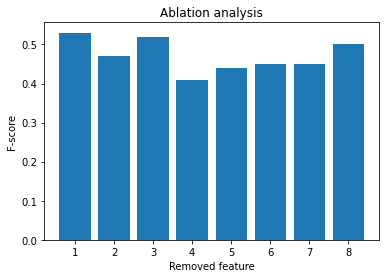

In [125]:
# Graphing
import matplotlib.pyplot as plt
Fscores = [0.53, 0.47, 0.52, 0.41, 0.44, 0.45, 0.45, 0.50]
features = ['None', 'Punctuation', 'Digits', 'Capitals', 'POS-tags', 'Function word frequency', 'N-gram frequency', 'Character frequency']
for i, f in enumerate(features):
    print(i + 1, ":", f)
plt.title("Ablation analysis")
plt.bar(np.arange(1, len(features) + 1), Fscores)
plt.xlabel("Removed feature")
plt.ylabel("F-score")
plt.show()